In [1]:
import pandas as pd
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Load the CSV files
train_df = pd.read_csv('Train.csv')
test_df = pd.read_csv('Test.csv')


# Data Preprocessing (Splitting Dataset and Stratified Sampling)

In [3]:
# Sample 600 images from each class, avoiding the warning
balanced_train_df = (
    train_df.groupby('class', as_index=False)  # Keep the grouping column
    .apply(lambda x: x.sample(n=600, random_state=42))
    .reset_index(drop=True)
)

# Split the balanced dataset into training and validation sets
train_data, val_data = train_test_split(
    balanced_train_df, 
    test_size=0.2, 
    random_state=42, 
    stratify=balanced_train_df['class']
)

# Sizes of the datasets
print("Size of Balanced Training Set:", balanced_train_df.shape[0])
print("Size of Training Set:", train_data.shape[0])
print("Size of Validation Set:", val_data.shape[0])
print("Size of Test Set:", test_df.shape[0])



Size of Balanced Training Set: 1800
Size of Training Set: 1440
Size of Validation Set: 360
Size of Test Set: 1178


C:\Users\selgo\AppData\Local\Temp\ipykernel_13036\3326931599.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=600, random_state=42))


# Data Analysis

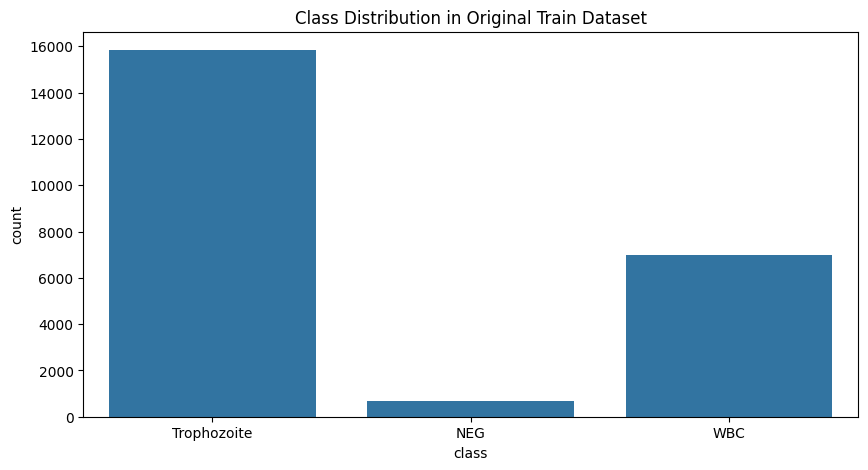

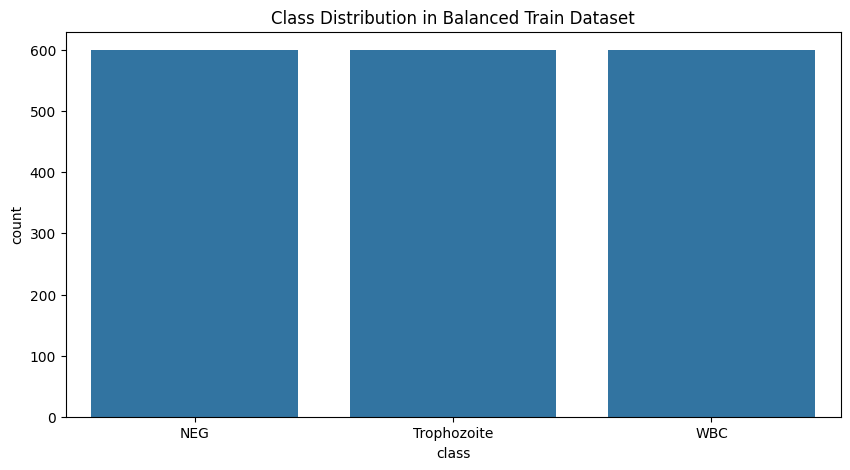

In [4]:
# 1. Plot class distribution in the original and balanced dataset
plt.figure(figsize=(10, 5))
sns.countplot(data=train_df, x='class')
plt.title("Class Distribution in Original Train Dataset")
plt.show()

plt.figure(figsize=(10, 5))
sns.countplot(data=balanced_train_df, x='class')
plt.title("Class Distribution in Balanced Train Dataset")
plt.show()

Sample image paths:
0    images\id_u3q6jdck4j.jpg
1    images\id_a6cl90trri.jpg
2    images\id_qvc2le9sm8.jpg
3    images\id_w8xnbd5rvm.jpg
4    images\id_6dop09rk02.jpg
Name: image_path, dtype: object
Available columns: ['Image_ID', 'class', 'confidence', 'ymin', 'xmin', 'ymax', 'xmax']


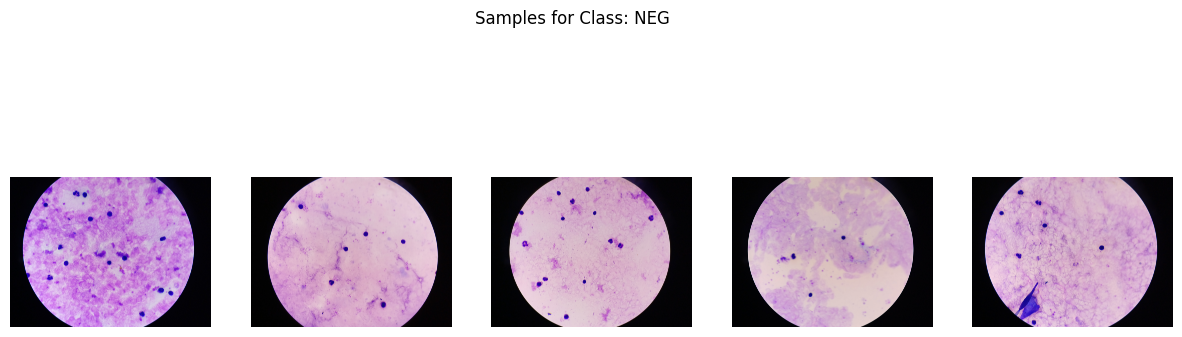

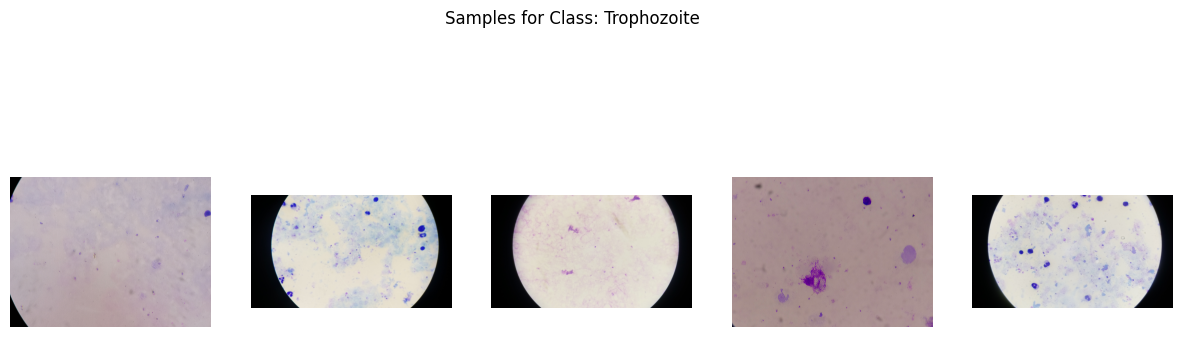

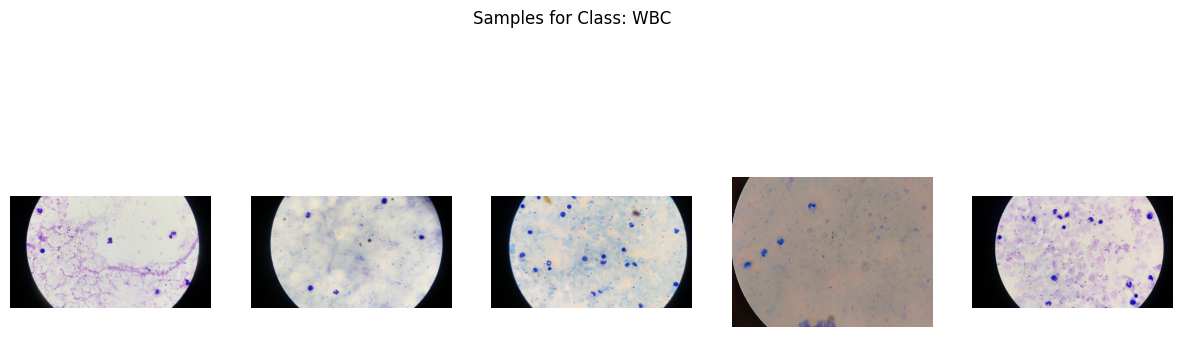

In [ ]:
# 2. Display sample images from each class

train_df['image_path'] = train_df['Image_ID'].apply(lambda x: os.path.join('images', x))

print("Sample image paths:")
print(train_df['image_path'].head())

print("Available columns:", balanced_train_df.columns.tolist())

balanced_train_df['image_path'] = balanced_train_df['Image_ID'].apply(
    lambda x: os.path.join('images', x)
)

missing_files = train_df[~train_df['image_path'].apply(os.path.exists)]
if not missing_files.empty:
    print(f"Missing files:\n{missing_files[['Image_ID', 'image_path']]}")


def plot_image_samples(df, class_name, n_samples=5):
    plt.figure(figsize=(15, 5))
    sample_df = df[df['class'] == class_name].sample(n=n_samples, random_state=42)
    for i, idx in enumerate(sample_df.index):
        img_path = sample_df.loc[idx, 'image_path']
        img = cv2.imread(img_path)
        
        if img is None: 
            print(f"Warning: Image at {img_path} not found.")
            continue
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, n_samples, i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(f'Samples for Class: {class_name}')
    plt.show()

for cls in balanced_train_df['class'].unique():
    plot_image_samples(balanced_train_df, cls)

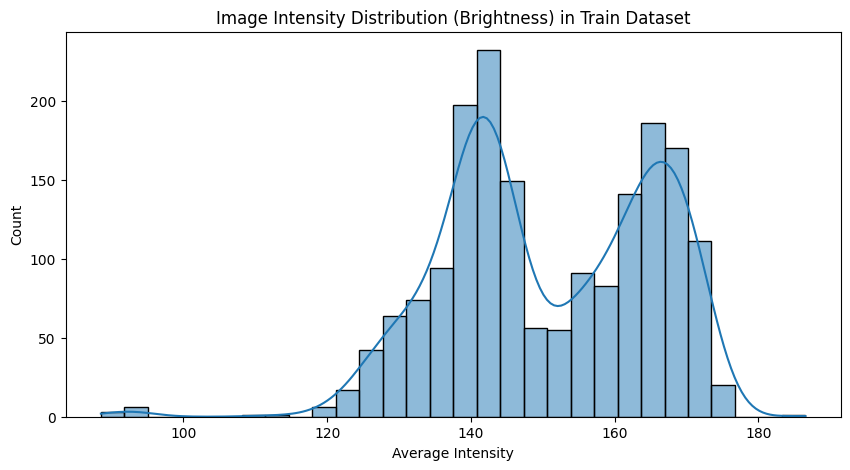

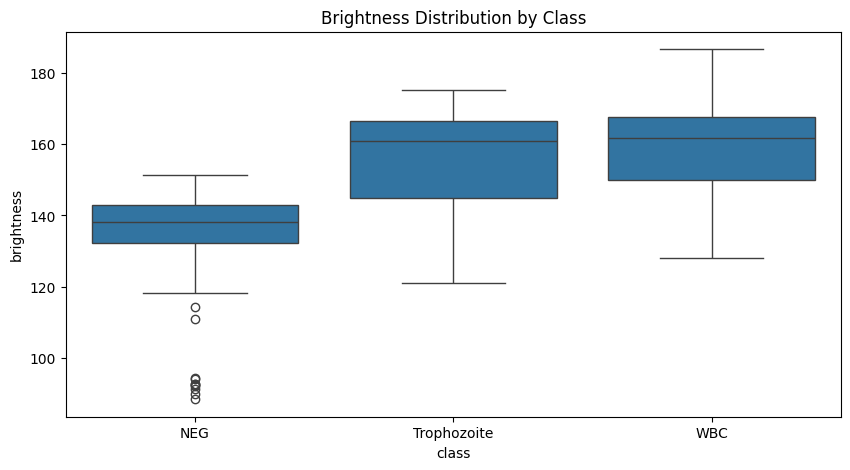

In [ ]:
# 3. Calculate image intensity distribution (brightness)
brightness = []

for img_path in balanced_train_df['image_path']:  
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    brightness.append(np.mean(img))

plt.figure(figsize=(10, 5))
sns.histplot(brightness, kde=True, bins=30)
plt.title("Image Intensity Distribution (Brightness) in Train Dataset")
plt.xlabel("Average Intensity")
plt.show()

# 4. Class-wise brightness comparison
brightness_class = []

for _, row in balanced_train_df.iterrows():
    img = cv2.imread(row['image_path'], cv2.IMREAD_GRAYSCALE)
    avg_brightness = np.mean(img)
    brightness_class.append((row['class'], avg_brightness))

brightness_df = pd.DataFrame(brightness_class, columns=['class', 'brightness'])

plt.figure(figsize=(10, 5))
sns.boxplot(data=brightness_df, x='class', y='brightness')
plt.title("Brightness Distribution by Class")
plt.show()

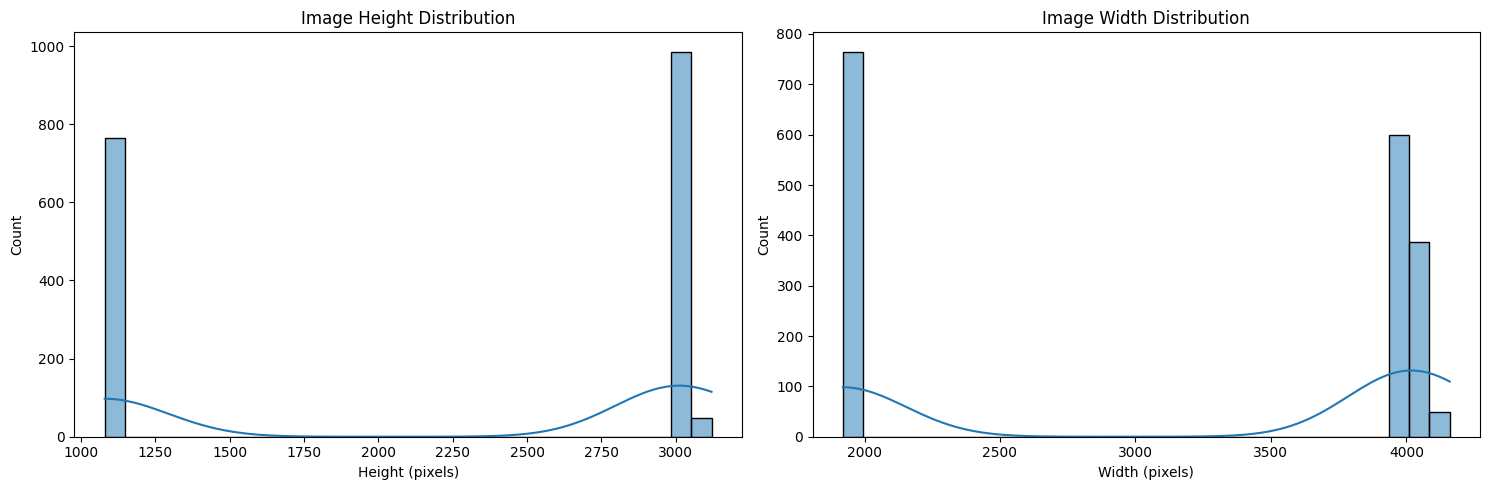

In [20]:
# 5. Image Size Distribution
def get_image_dimensions(img_path):
    img = cv2.imread(img_path)
    if img is not None:
        return img.shape[0], img.shape[1]
    return None, None

heights = []
widths = []

for img_path in balanced_train_df['image_path']:
    h, w = get_image_dimensions(img_path)
    if h is not None and w is not None:
        heights.append(h)
        widths.append(w)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.histplot(heights, bins=30, kde=True)
plt.title("Image Height Distribution")
plt.xlabel("Height (pixels)")

plt.subplot(1, 2, 2)
sns.histplot(widths, bins=30, kde=True)
plt.title("Image Width Distribution")
plt.xlabel("Width (pixels)")
plt.tight_layout()
plt.show()

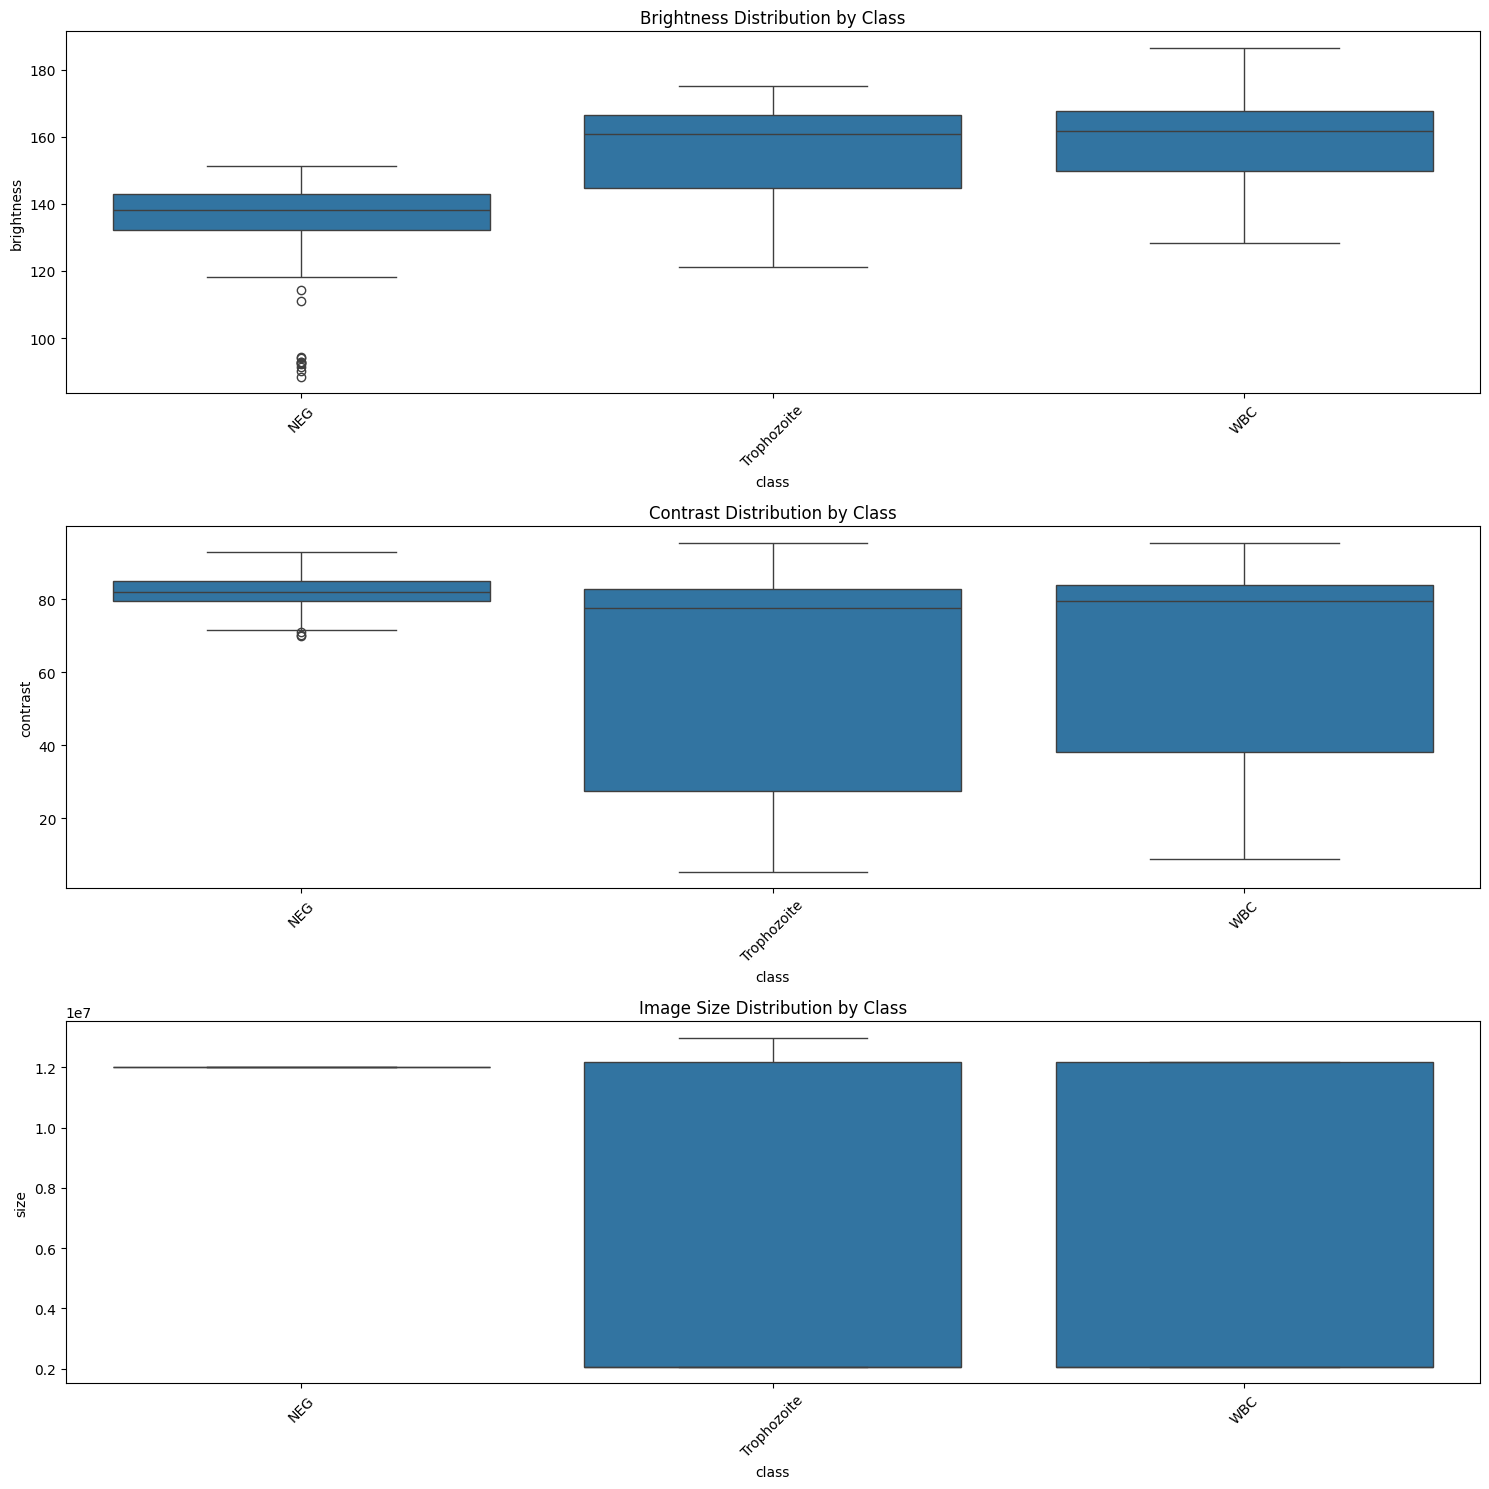

In [21]:
# 6. Image Statistics by Class
class_stats = []

for _, row in balanced_train_df.iterrows():
    img = cv2.imread(row['image_path'])
    if img is not None:
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        class_stats.append({
            'class': row['class'],
            'brightness': np.mean(img_gray),
            'contrast': np.std(img_gray),
            'size': img.shape[0] * img.shape[1]
        })

stats_df = pd.DataFrame(class_stats)

# Plot statistics by class
fig, axes = plt.subplots(3, 1, figsize=(15, 15))

sns.boxplot(data=stats_df, x='class', y='brightness', ax=axes[0])
axes[0].set_title('Brightness Distribution by Class')
axes[0].tick_params(axis='x', rotation=45)

sns.boxplot(data=stats_df, x='class', y='contrast', ax=axes[1])
axes[1].set_title('Contrast Distribution by Class')
axes[1].tick_params(axis='x', rotation=45)

sns.boxplot(data=stats_df, x='class', y='size', ax=axes[2])
axes[2].set_title('Image Size Distribution by Class')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

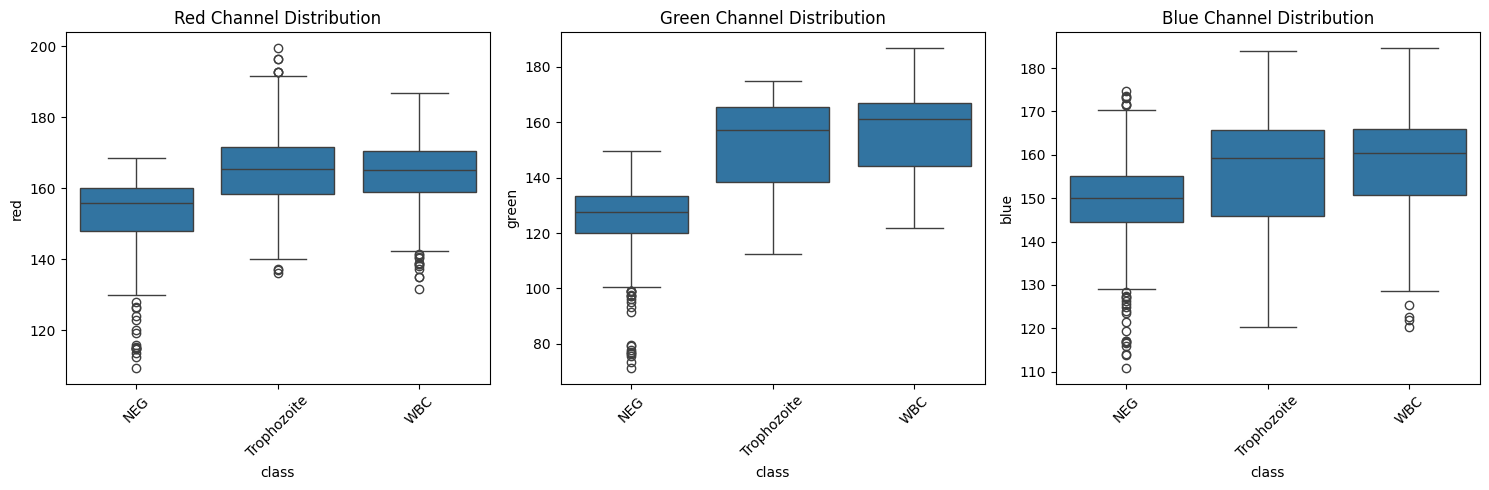

In [22]:
# 7. Color Distribution Analysis
def get_color_distribution(image_path):
    img = cv2.imread(image_path)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return [np.mean(img[:,:,0]), np.mean(img[:,:,1]), np.mean(img[:,:,2])]
    return None

color_stats = []
for _, row in balanced_train_df.iterrows():
    colors = get_color_distribution(row['image_path'])
    if colors:
        color_stats.append({
            'class': row['class'],
            'red': colors[0],
            'green': colors[1],
            'blue': colors[2]
        })

color_df = pd.DataFrame(color_stats)

# Plot RGB distributions
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.boxplot(data=color_df, x='class', y='red')
plt.title('Red Channel Distribution')
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
sns.boxplot(data=color_df, x='class', y='green')
plt.title('Green Channel Distribution')
plt.xticks(rotation=45)


plt.subplot(1, 3, 3)
sns.boxplot(data=color_df, x='class', y='blue')
plt.title('Blue Channel Distribution')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

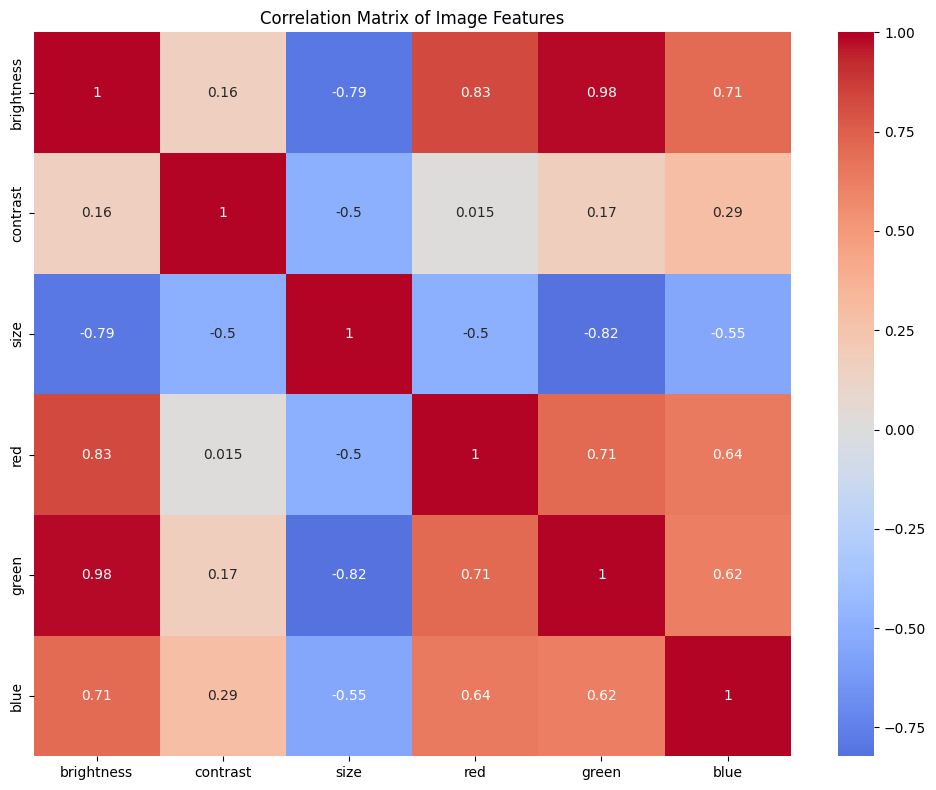

In [23]:
# 8. Correlation Matrix of Image Features
feature_df = pd.DataFrame({
    'brightness': stats_df['brightness'],
    'contrast': stats_df['contrast'],
    'size': stats_df['size'],
    'red': color_df['red'],
    'green': color_df['green'],
    'blue': color_df['blue']
})

plt.figure(figsize=(10, 8))
sns.heatmap(feature_df.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Image Features')
plt.tight_layout()
plt.show()

In [24]:
# Reset index for both dataframes
train_data = train_data.reset_index(drop=True)
val_data = val_data.reset_index(drop=True)

# Data Preprocessing (Categorial Encoding)

In [25]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    channel_shift_range=0.1
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory='images',
    x_col='Image_ID',
    y_col='class',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_data,
    directory='images',
    x_col='Image_ID',
    y_col='class',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory='images',
    x_col='Image_ID',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False
    
)


print("Class Indices:")
print(train_generator.class_indices)

print("\nNumber of classes:", len(train_generator.class_indices))

class_labels = [k for k, v in sorted(train_generator.class_indices.items(), key=lambda item: item[1])]
print("\nClass labels in order:", class_labels)

print("\nSamples per class:")
for class_name, index in train_generator.class_indices.items():
    count = len(train_data[train_data['class'] == class_name])
    print(f"{class_name}: {count} samples")

Found 1440 validated image filenames belonging to 3 classes.
Found 360 validated image filenames belonging to 3 classes.
Found 1178 validated image filenames.
Class Indices:
{'NEG': 0, 'Trophozoite': 1, 'WBC': 2}

Number of classes: 3

Class labels in order: ['NEG', 'Trophozoite', 'WBC']

Samples per class:
NEG: 480 samples
Trophozoite: 480 samples
WBC: 480 samples


In [26]:

print(f"Number of classes: {len(train_generator.class_indices)}")
print(f"Number of training samples: {len(train_generator)}")
print(f"Number of validation samples: {len(val_generator)}")
print(f"Number of test samples: {len(test_generator)}")

print("\nClass distribution in training data:")
print(train_data['class'].value_counts(normalize=True))
print("\nClass distribution in validation data:")
print(val_data['class'].value_counts(normalize=True))

Number of classes: 3
Number of training samples: 45
Number of validation samples: 12
Number of test samples: 37

Class distribution in training data:
class
WBC            0.333333
Trophozoite    0.333333
NEG            0.333333
Name: proportion, dtype: float64

Class distribution in validation data:
class
Trophozoite    0.333333
WBC            0.333333
NEG            0.333333
Name: proportion, dtype: float64


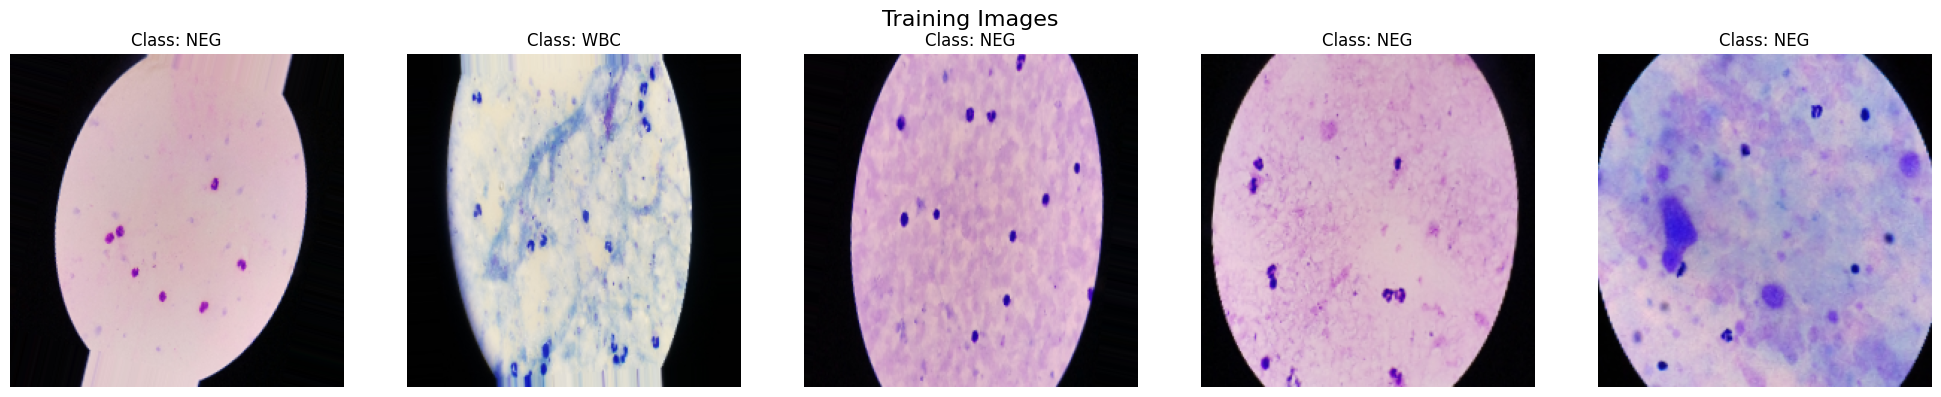

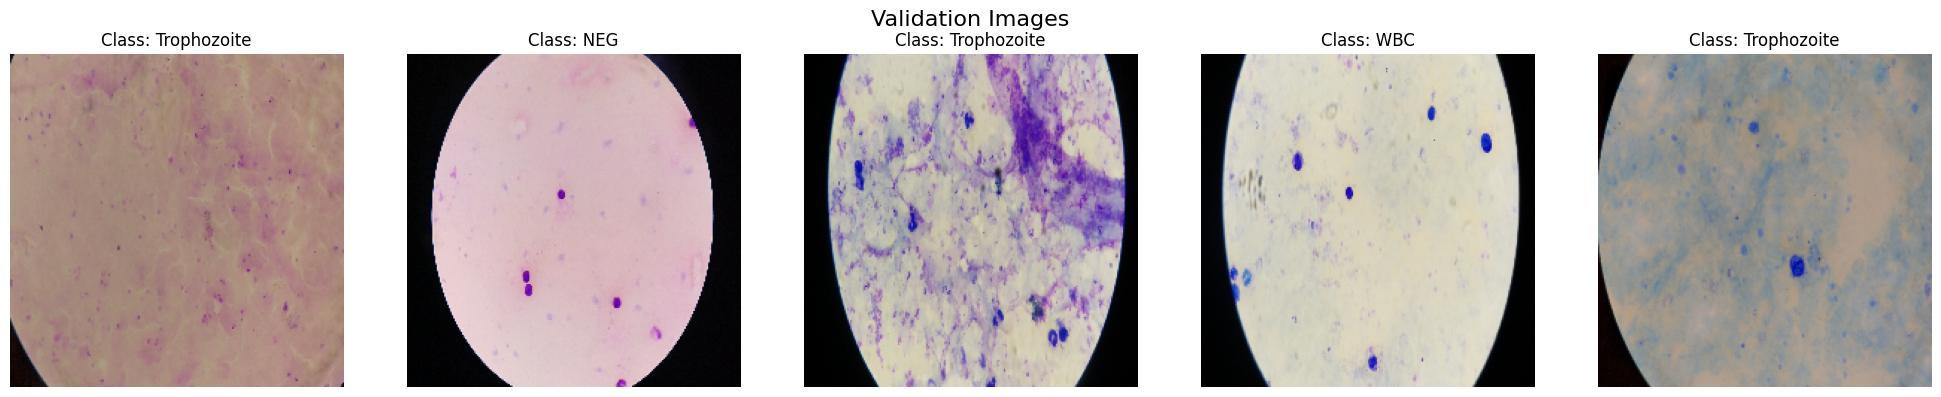

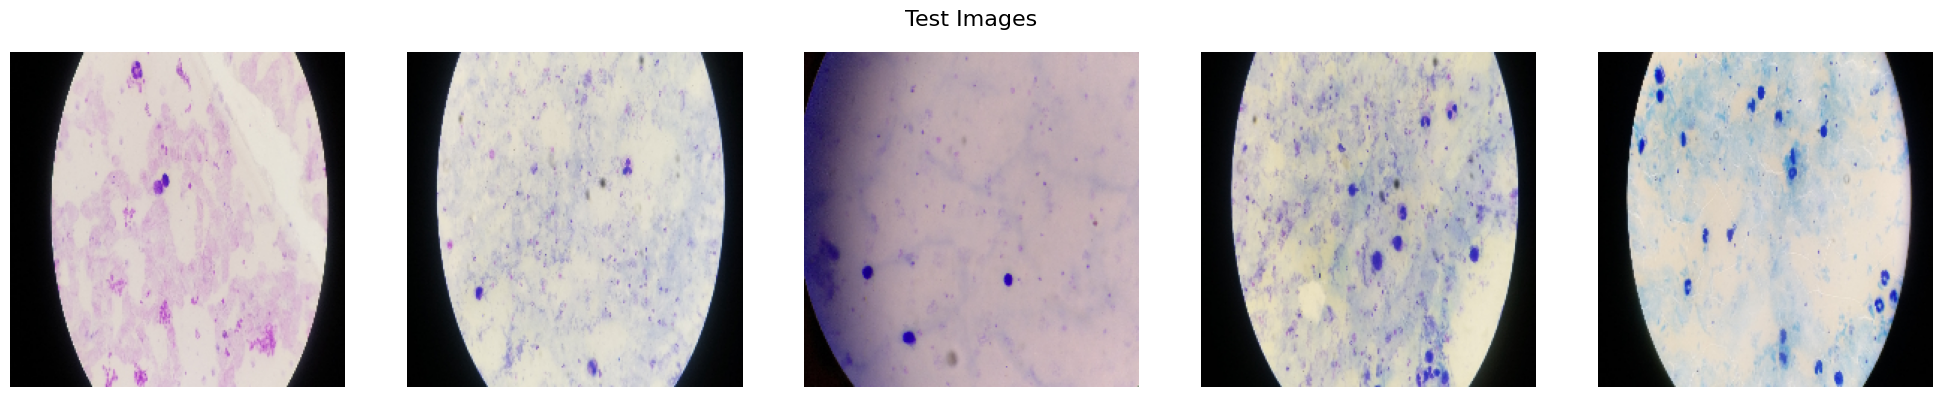

In [27]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def plot_images(generator, title, n=5):
    plt.figure(figsize=(20, 4))
    plt.suptitle(title, fontsize=16)
    
    has_classes = hasattr(generator, 'class_indices')
    
    if has_classes:
        class_indices = generator.class_indices
        index_to_class = {v: k for k, v in class_indices.items()}
    
    for i in range(n):
        batch = next(generator)
        
        if isinstance(batch, tuple):
            images, labels = batch
        else:
            images = batch
        
        idx = np.random.randint(0, images.shape[0])
        img = images[idx]
        
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.axis('off')
        
        if has_classes and isinstance(batch, tuple):
            label_idx = np.argmax(labels[idx])
            class_name = index_to_class[label_idx]
            plt.title(f"Class: {class_name}")
    
    plt.tight_layout()
    plt.show()

plot_images(train_generator, "Training Images")

plot_images(val_generator, "Validation Images")

plot_images(test_generator, "Test Images")

# Classification Model

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [29]:
# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])




c:\Users\selgo\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, min_lr=0.0001)

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    validation_steps=None,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50


c:\Users\selgo\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


45/45 ━━━━━━━━━━━━━━━━━━━━ 139s 3s/step - accuracy: 0.4492 - loss: 1.0877 - val_accuracy: 0.6278 - val_loss: 0.6133 - learning_rate: 0.0010
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 136s 3s/step - accuracy: 0.6418 - loss: 0.6516 - val_accuracy: 0.7056 - val_loss: 0.4897 - learning_rate: 0.0010
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - accuracy: 0.6384 - loss: 0.5690 - val_accuracy: 0.4333 - val_loss: 1.5923 - learning_rate: 0.0010
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 129s 3s/step - accuracy: 0.6650 - loss: 0.5551 - val_accuracy: 0.6556 - val_loss: 0.5594 - learning_rate: 0.0010
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 134s 3s/step - accuracy: 0.6891 - loss: 0.4825 - val_accuracy: 0.6972 - val_loss: 0.5093 - learning_rate: 0.0010
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 133s 3s/step - accuracy: 0.7095 - loss: 0.5001 - val_accuracy: 0.7111 - val_loss: 0.4695 - learning_rate: 2.0000e-04
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 130s 3s/step - accuracy: 0.7216 - loss: 0.4605 - val_accuracy: 

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [ ]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(val_generator)
print(f"Test accuracy: {test_accuracy:.4f}")

In [ ]:
import random

In [ ]:
def plot_sample_predictions(model, val_generator, val_data, num_samples=10):
    batch_x, batch_y = next(val_generator)
    
    predictions = model.predict(batch_x)
    
    class_labels = list(val_generator.class_indices.keys())
    
    indices = random.sample(range(len(batch_x)), num_samples)
    
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.ravel()
    
    for i, idx in enumerate(indices):
        img = batch_x[idx]
        true_label = class_labels[np.argmax(batch_y[idx])]
        
        pred_label = class_labels[np.argmax(predictions[idx])]
        confidence = np.max(predictions[idx])
        
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}")
    
    plt.tight_layout()
    plt.show()

plot_sample_predictions(model, val_generator, val_data)

In [ ]:
predictions = model.predict(test_generator, steps=len(test_df) // batch_size + 1)

class_labels = list(train_generator.class_indices.keys())

results_df = pd.DataFrame({
    'Image_ID': test_df['Image_ID'],
    'Predicted_Class': [class_labels[np.argmax(pred)] for pred in predictions],
    'Confidence': [np.max(pred) for pred in predictions]
})

In [ ]:
results_df.head()